# **Deep Neural Networks**

In this practice, we will work with a neural network composed of an input layer, 3 hidden layers, and an output layer.

- Overfitting / Underfitting
- Dropout
- Parameter Inicialization
- Early Stopping


In [1]:
#@title Data and Imports

# General modules
import numpy as np
import pandas as pd

# Data processing modules
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Dataset



Let's create a synthetic dataset to do the experiments. The *make_classification* function from the *sklearn.datasets* module is used to generate a synthetic dataset for classification tasks. The parameters passed to this function determine the characteristics of the dataset.

We will use a dataset composed of two classes and 1000 rows.

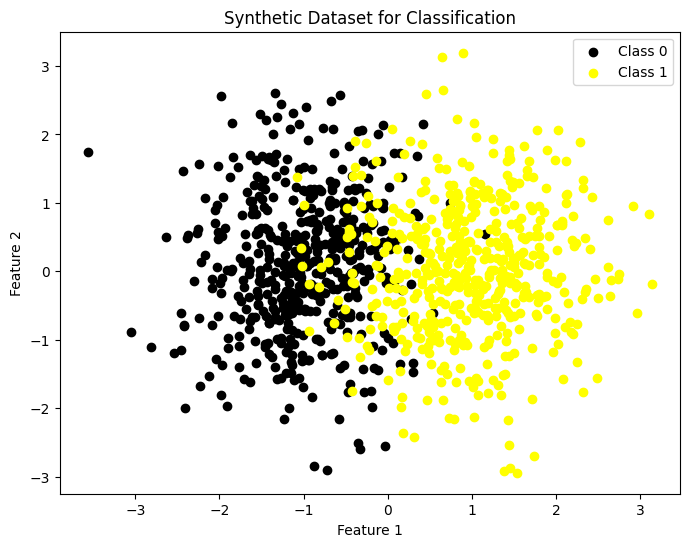

In [2]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=1, n_redundant=0,
                           n_clusters_per_class=1, flip_y=0, class_sep=1, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='black', marker='o', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', marker='o', label='Class 1')
plt.title('Synthetic Dataset for Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [3]:
y = pd.get_dummies(y).values  # One-hot encode the target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Deep Neural Network

In [4]:
#@title Activation Functions

def sigmoid(x):
    # Clip values to avoid overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu_derivative(x):
    return (x > 0).astype(int)

In [5]:
#@title Loss Function

def loss_function(y_true, y_pred):
  epsilon = np.finfo(float).eps
  return -np.mean(y_true * np.log(y_pred + epsilon))

def loss_function_derivative(y_true, y_pred):
    epsilon = np.finfo(float).eps
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

In [6]:
#@title Auxiliary Functions

def evaluate_accuracy(model, x, y):
    predictions = model.predict(x)
    accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))
    return accuracy

def plot_losses(all_losses):
    plt.figure(figsize=(10, 6))
    for i, fold_losses in enumerate(all_losses):
        plt.plot(range(1, len(fold_losses) + 1), fold_losses, label=f'Fold {i + 1}')

    average_losses = np.mean(all_losses, axis=0)
    plt.plot(range(1, len(average_losses) + 1), average_losses, label='Average', linewidth=2, color='black')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses Across Folds')
    plt.legend()
    plt.show()

def summary(model):
    # Return string
    summary = ''
    summary += "\nModel Architecture:\n"
    summary += "=" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Layer Type", "Nº of Neurons")
    summary += "-" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Input Layer", str(model.layer_sizes[0]))
    summary += "-" * 20 + "\n"
    for i in range(1, len(model.layer_sizes) - 1):
        summary += "{:<20} {:<20}\n".format("Hidden Layer " + str(i), str(model.layer_sizes[i]))
        summary += "-" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Output Layer", str(model.layer_sizes[-1]))
    summary += "=" * 20 + "\n"

    return summary

# Auxiliary function to plot the decision boundary
def plot_decision_boundary(model, x):
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5

    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    return xx, yy, Z

In [7]:
#@title Neural Network

class DL_Model:
    def __init__(self, learning_rate, epochs, layer_sizes, dropout_prob=0):
        self.weights = {}
        self.biases = {}
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.layer_sizes = layer_sizes
        self.input_size = layer_sizes[0]
        self.output_size = layer_sizes[-1]
        self.dropout_prob = dropout_prob
        self.losses = []
        self.val_losses = []
        self.random_state = np.random.RandomState(42)

    def initialize_parameters(self):
        # Initialize weights and biases
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] = self.random_state.randn(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.zeros((1, self.layer_sizes[i + 1]))

    def forward(self, x):
        # Forward pass
        self.activations = {}
        self.activations[0] = x
        for i in range(len(self.layer_sizes) - 1):
            self.activations[i + 1] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            if i != len(self.layer_sizes) - 2:
                self.activations[i + 1] = relu(self.activations[i + 1])
            else:
                self.activations[i + 1] = sigmoid(self.activations[i + 1])

    def backward(self, y):
        # Backward pass
        self.gradients = {}
        loss_derivative = loss_function_derivative(y, self.activations[len(self.layer_sizes) - 1])
        self.gradients[len(self.layer_sizes) - 2] = loss_derivative
        for i in range(len(self.layer_sizes) - 2, 0, -1):
            self.gradients[i - 1] = np.dot(self.gradients[i], self.weights[i].T) * relu_derivative(self.activations[i])

    def clip_gradients(self):
        max_grad_norm = 1.0
        for i in range(len(self.layer_sizes) - 1):
            grad_norm = np.linalg.norm(self.gradients[i])
            if grad_norm > max_grad_norm:
                scale = max_grad_norm / (grad_norm + 1e-6)  # Avoid division by zero
                self.gradients[i] *= scale

    def update_parameters(self):
        # Update weights and biases
        self.clip_gradients()
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] -= self.learning_rate * np.dot(self.activations[i].T, self.gradients[i])
            self.biases[i] -= self.learning_rate * np.sum(self.gradients[i], axis=0, keepdims=True)

    def fit(self, x, y, validation_data=None):
        self.initialize_parameters()
        for _ in range(self.epochs):
            self.forward(x)
            self.backward(y)
            self.update_parameters()
            self.losses.append(loss_function(y, self.activations[len(self.layer_sizes) - 1]))

            x_val, y_val = validation_data
            self.forward(x_val)
            self.val_losses.append(loss_function(y_val, self.activations[len(self.layer_sizes) - 1]))
            print(f"\rEpoch:{_+1}, Loss:{self.losses[-1]:.4f}, Val Loss:{self.losses[-1]:.4f}",end="")

    def predict(self, x):
        self.forward(x)
        return self.activations[len(self.layer_sizes) - 1]

# Train and Predict

In [8]:
#@title Hyperparameters initialization

input_size = x_train.shape[1]
output_size = y_train.shape[1]
hidden_layers = [512, 128, 32, 32]
layer_sizes = [input_size] + hidden_layers + [output_size]
learning_rate = 0.0001
epochs = 1000

In [9]:
#@title Training

nn = DL_Model(learning_rate, epochs, layer_sizes)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

Epoch:1000, Loss:0.1177, Val Loss:0.1177

Accuracy: 0.915


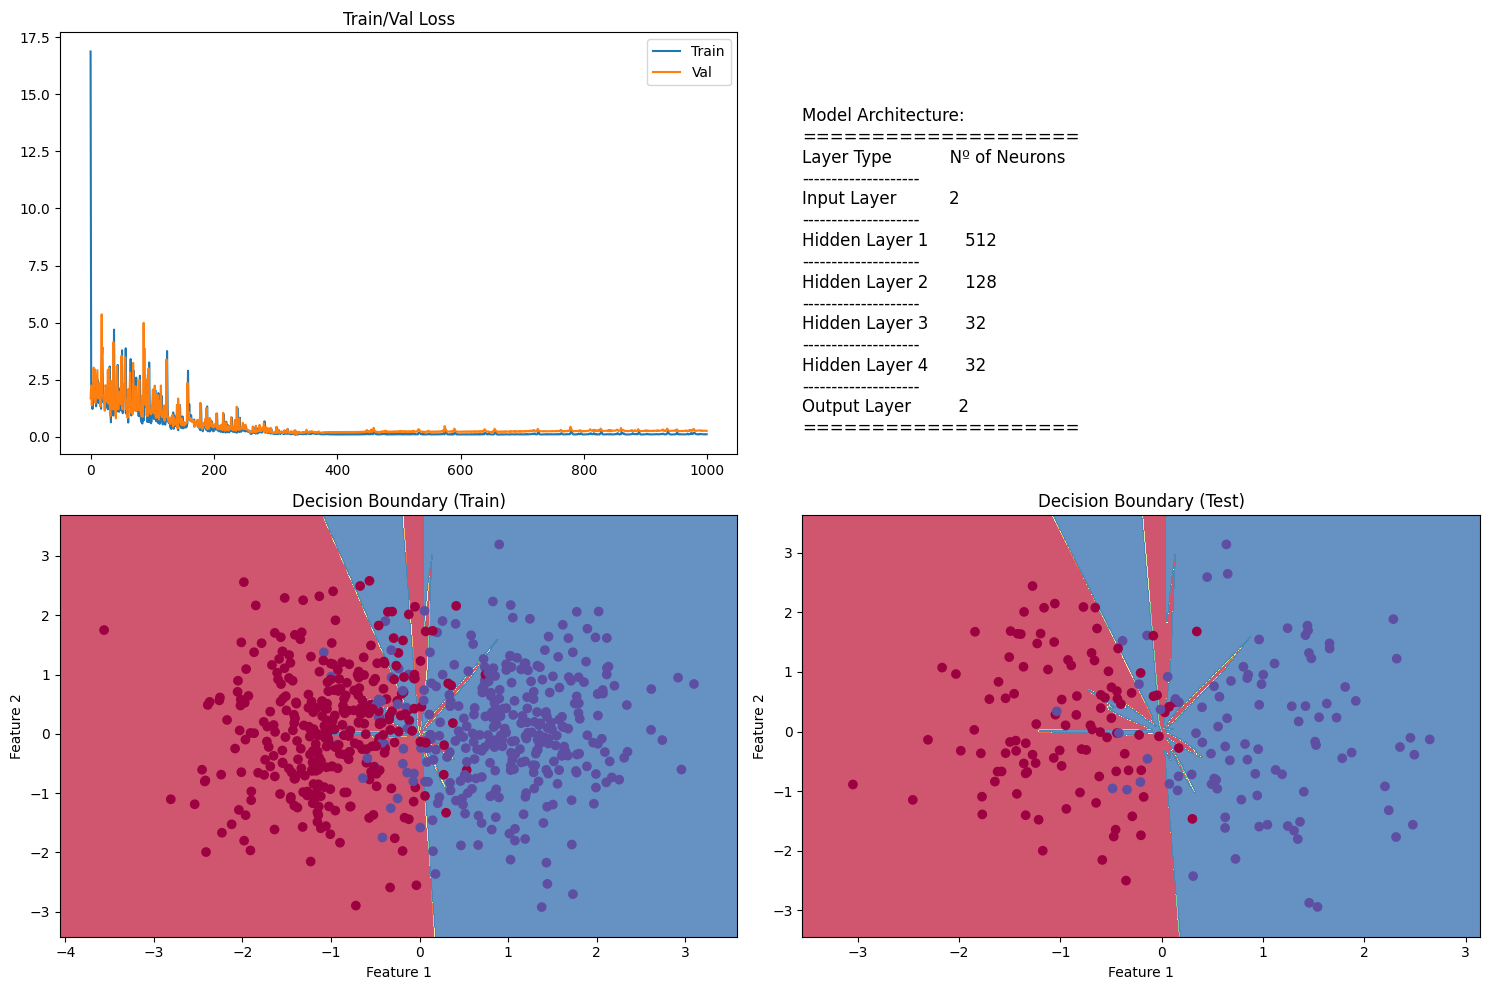

In [10]:
#@title Plot results

accuracy = []
xx_train, yy_train = [], []
xx_test, yy_test = [], []
Z_train, Z_test = [], []

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[0])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Train/Val Loss")
axes[0, 0].legend(['Train', 'Val'])

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[0], yy_train[0], Z_train[0], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[0], yy_test[0], Z_test[0], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# **Questions**


1. **How did the model's performance evolve over time?**

Lo que se puede observar es que el modelo tiene un comportamiento de overfitting, ya que el error de entrenamiento disminuye con el tiempo, pero el error de validación aumenta. Esto se puede observar en la gráfica de la función de pérdida y la precisión.

# Improving our neural network

Now we are going to implement some techniques to improve the performance of our neural network during training so that it generalizes better before the test data.

# Parameter inizialization

**Xavier Initialization** is a technique designed to address the issue of maintaining a constant variance for activations throughout the layers of a deep neural network. The primary objective is to prevent the gradients from becoming too small or too large, a phenomenon often referred to as the vanishing or exploding gradients problem. This approach is particularly important because if the variance of the activations varies significantly across layers, it can lead to unstable convergence behavior during training.

Unlike random initialization, which draws weights from a zero-mean Gaussian distribution and risks unstable activations, Xavier Initialization uses a uniform distribution bounded by: \

 $$
\pm \frac{\sqrt{6}}{\sqrt{n_i + n_{i+1}}}
$$

where $n_{i}$ and $n_{i+1}$ represent the number of neurons in the adjacent layers. This method promotes stable convergence during training and is particularly beneficial for deep networks, as discussed in [Understanding the difficulty of training deep feedforward neural networks](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

**He Initialization**, also known as He Normal Initialization, is a technique designed for initializing the weights of deep neural networks that use ReLU activation functions. The key idea behind He Initialization is to set the initial weights of the network such that the variance remains the same for both inputs and outputs throughout the network.

$$
  \sqrt{\frac{2}{n_i}}
$$

In [11]:
# Replace the function
# To-Do
# n_i = self.layer_sizes[i]
def initialize_parameters(self):
    # Initialize weights and biases
    for i in range(len(self.layer_sizes) - 1):
        if i < len(self.layer_sizes) - 2:  # He initialization for ReLU (all layers except last)
            std_dev = np.sqrt(2 / self.layer_sizes[i])
        else:  # Xavier initialization for Sigmoid (last layer)
            std_dev = np.sqrt(1 / self.layer_sizes[i])
        self.weights[i] = self.random_state.normal(0, std_dev, (self.layer_sizes[i], self.layer_sizes[i + 1]))
        self.biases[i] = np.zeros((1, self.layer_sizes[i + 1]))

# Replace the function
DL_Model.initialize_parameters = initialize_parameters

In [12]:
nn = DL_Model(learning_rate, epochs, layer_sizes)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

Epoch:1000, Loss:0.1029, Val Loss:0.1029

Accuracy: 0.92


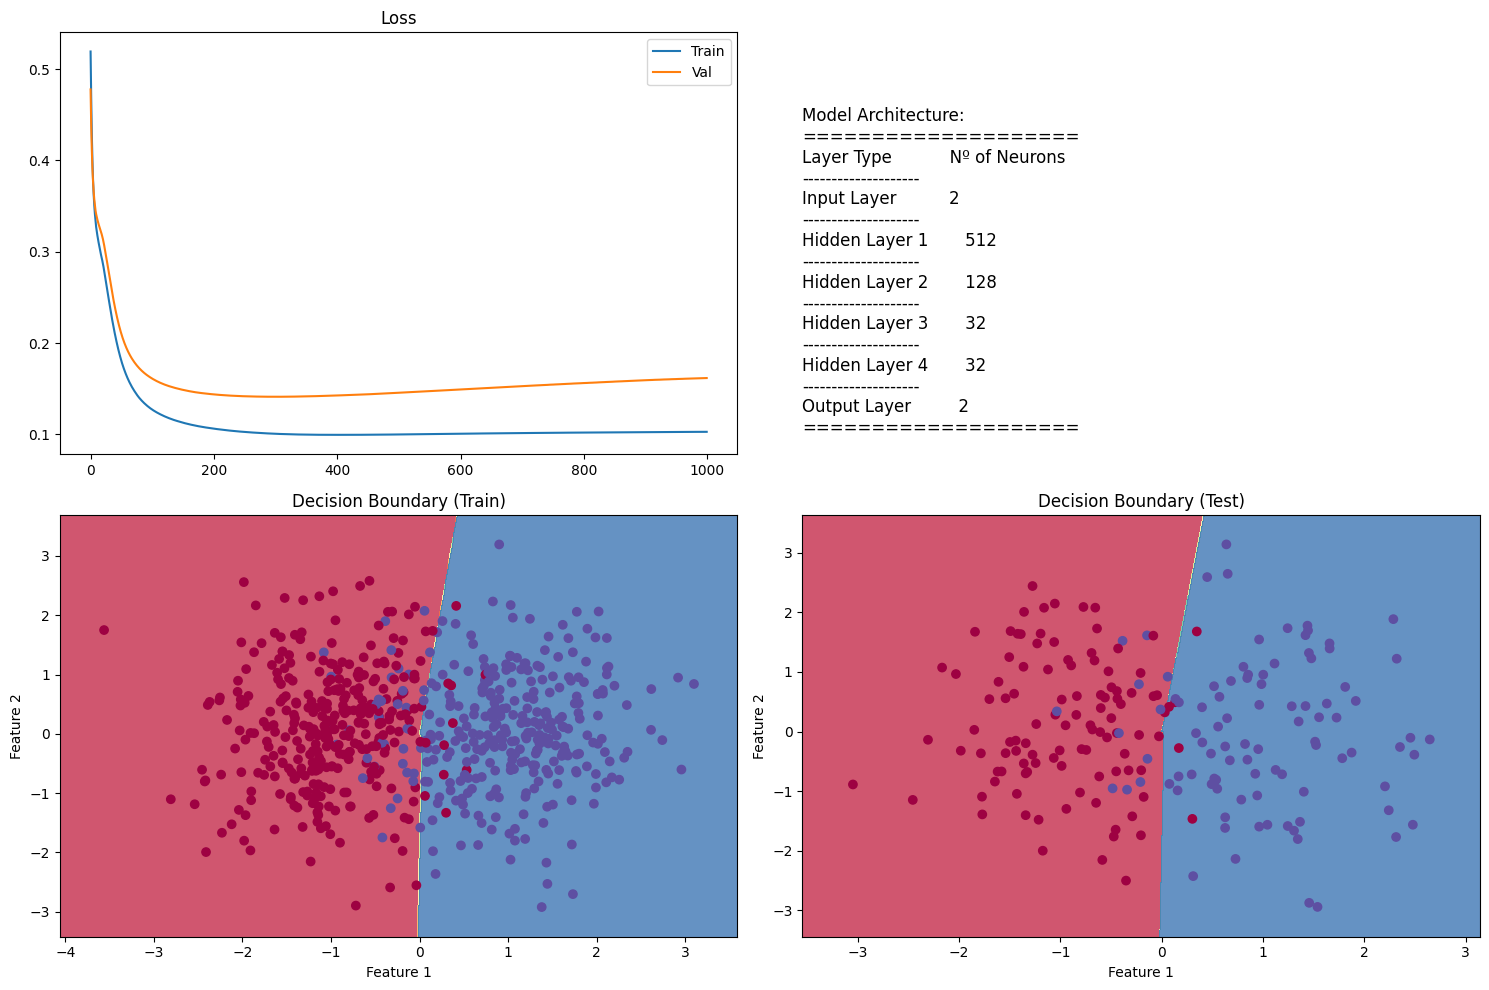

In [13]:
#@title Plot results
accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[1])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Loss")
axes[0, 0].legend(['Train', 'Val'])

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[1], yy_train[1], Z_train[1], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[1], yy_test[1], Z_test[1], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Dropout

We are going to adapt the feed-forward and backpropagation functions in order to apply dropout.

In [14]:
# Feed forward with dropout
def forward_with_dropout(self, x):
    # Forward pass
    self.activations = {}
    self.activations[0] = x
    self.dropout_masks = {}
    for i in range(len(self.layer_sizes) - 1):
        self.activations[i + 1] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
        if i != len(self.layer_sizes) - 2:
            self.activations[i + 1] = relu(self.activations[i + 1])
            self.activations[i + 1], self.dropout_masks[i] = self.apply_dropout(self.activations[i + 1])
        else:
            self.activations[i + 1] = sigmoid(self.activations[i + 1])

def backward_with_dropout(self, y):
    # Backward pass
    self.gradients = {}
    loss_derivative = loss_function_derivative(y, self.activations[len(self.layer_sizes) - 1])
    self.gradients[len(self.layer_sizes) - 2] = loss_derivative
    for i in range(len(self.layer_sizes) - 2, 0, -1):
        self.gradients[i - 1] = np.dot(self.gradients[i], self.weights[i].T) * relu_derivative(self.activations[i])
        self.gradients[i - 1] *= self.dropout_masks[i - 1]

DL_Model.forward = forward_with_dropout
DL_Model.backpropagation = backward_with_dropout

Implementing dropout will help in preventing overfitting by randomly disabling a subset of neurons during each training iteration, thus forcing the network to learn more robust features that are not reliant on any specific set of neurons. This technique often results in a more generalized model with better performance on unseen data.



In [15]:
def apply_dropout(self, a):
        # Generate a random matrix D with the same shape as the input activations (a).
        # Each element of D is drawn from a uniform distribution over [0, 1).
        # Note: use self.random_state to generate randoms
        D = self.random_state.rand(*a.shape)

        # Create a dropout mask by setting elements of D to 1 if they are less than
        # the dropout probability (self.dropout_prob), else to 0.
        # This mask will randomly "drop" a portion of the activations.
        dropout_mask = (D < self.dropout_prob).astype(int)

        # Apply the dropout mask to the activations (a).
        # This sets a subset of a's elements to zero, effectively "dropping" them.
        a_dropped = a * dropout_mask

        # To compensate for the reduced number of active neurons, we scale up the remaining activations.
        # This is done to maintain the expected sum of activations, which is important for
        # not altering the behavior of the layer during inference.
        a_scaled = a_dropped / (1 - self.dropout_prob)

        return a_scaled, dropout_mask

DL_Model.apply_dropout = apply_dropout

In [16]:
# Ahora entrena la red con el dropout implentado
nn = DL_Model(learning_rate, epochs, layer_sizes, dropout_prob=0.1)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

Epoch:1000, Loss:0.3467, Val Loss:0.3467

Accuracy: 0.53


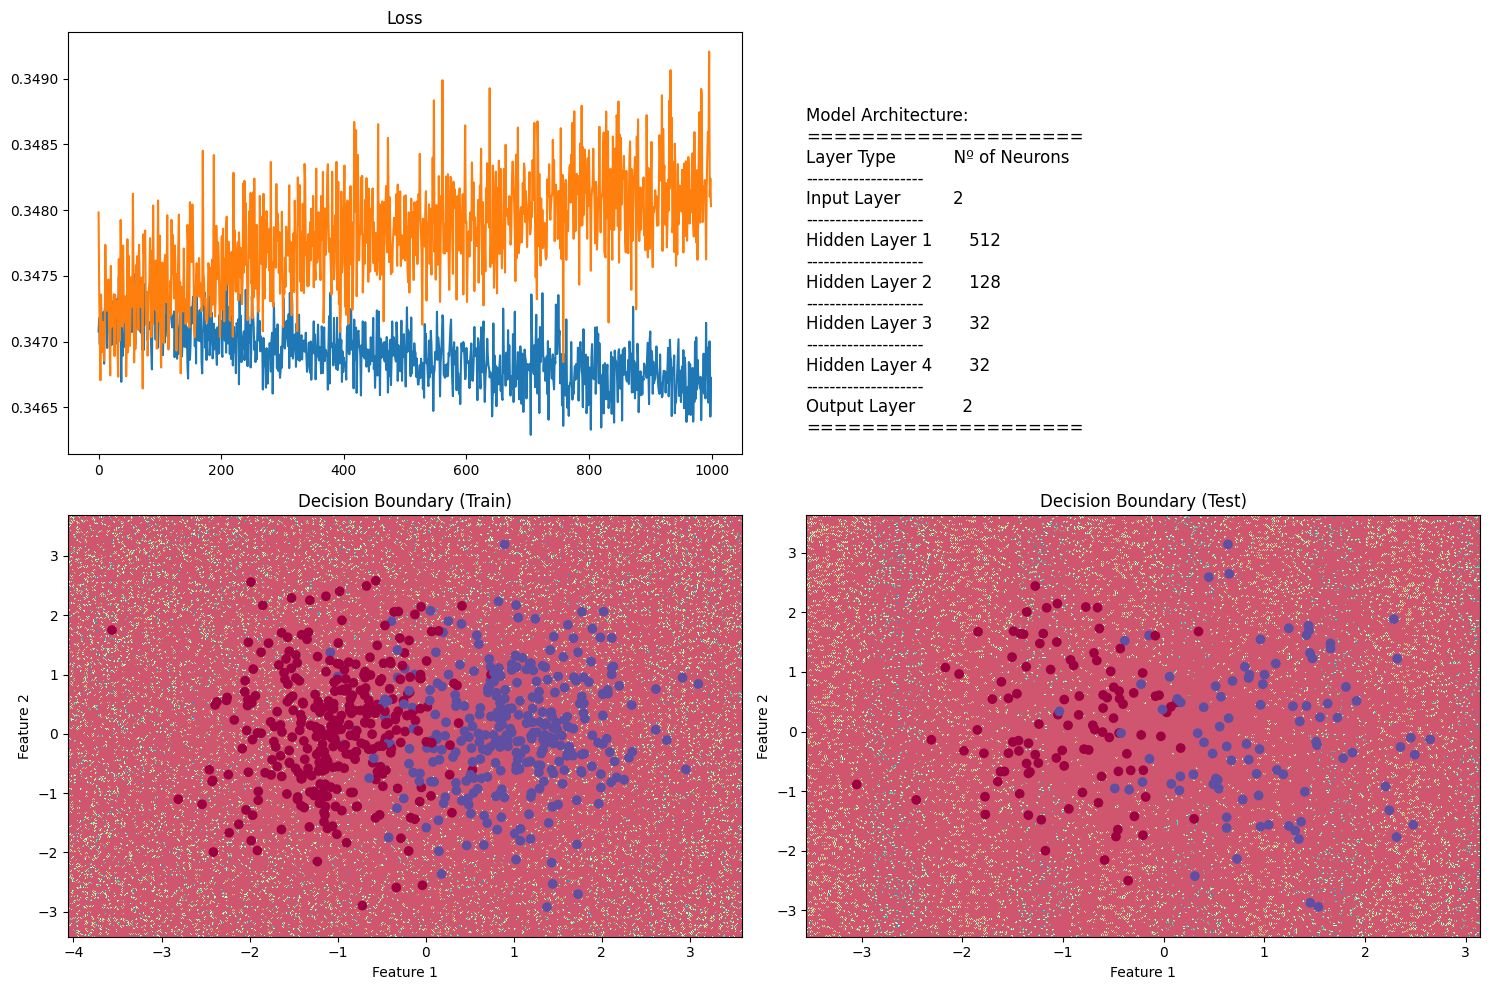

In [17]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[2])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Loss")

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[2], yy_train[2], Z_train[2], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[2], yy_test[2], Z_test[2], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Early Stopping

Based on our results, we can estimate that after 2500 epochs, our model stats overfitting to the training set.

Early stopping halts the training process once the model’s performance on a validation set starts to deteriorate, thereby preventing the model from learning noise and irrelevant patterns in the training data. By stopping the training early, it saves computational resources and time, as the model no longer processes through unnecessary epochs of training that don’t improve generalization.

In [18]:
# Early Stopping
def fit(self, x, y, batch_size=32, validation_data=None, patience=10):
    self.initialize_parameters()

    best_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(self.epochs):
        self.forward(x)
        self.backward(y)
        self.update_parameters()
        self.losses.append(loss_function(y, self.activations[len(self.layer_sizes) - 1]))

        if validation_data is not None:
            x_val, y_val = validation_data
            self.forward(x_val)
            val_loss = loss_function(y_val, self.activations[len(self.layer_sizes) - 1])
            self.val_losses.append(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                break

        print(f"\rEpoch: {epoch + 1}, Loss: {self.losses[-1]:.4f}, Val Loss: {self.val_losses[-1]:.4f}", end="")

# Replace the function
DL_Model.fit = fit

In [19]:
nn = DL_Model(learning_rate, epochs, layer_sizes, dropout_prob=0.5)
nn.fit(x_train, y_train, validation_data=(x_val, y_val), patience=15)

Epoch: 30, Loss: 1.0879, Val Loss: 1.4762

Accuracy: 0.505


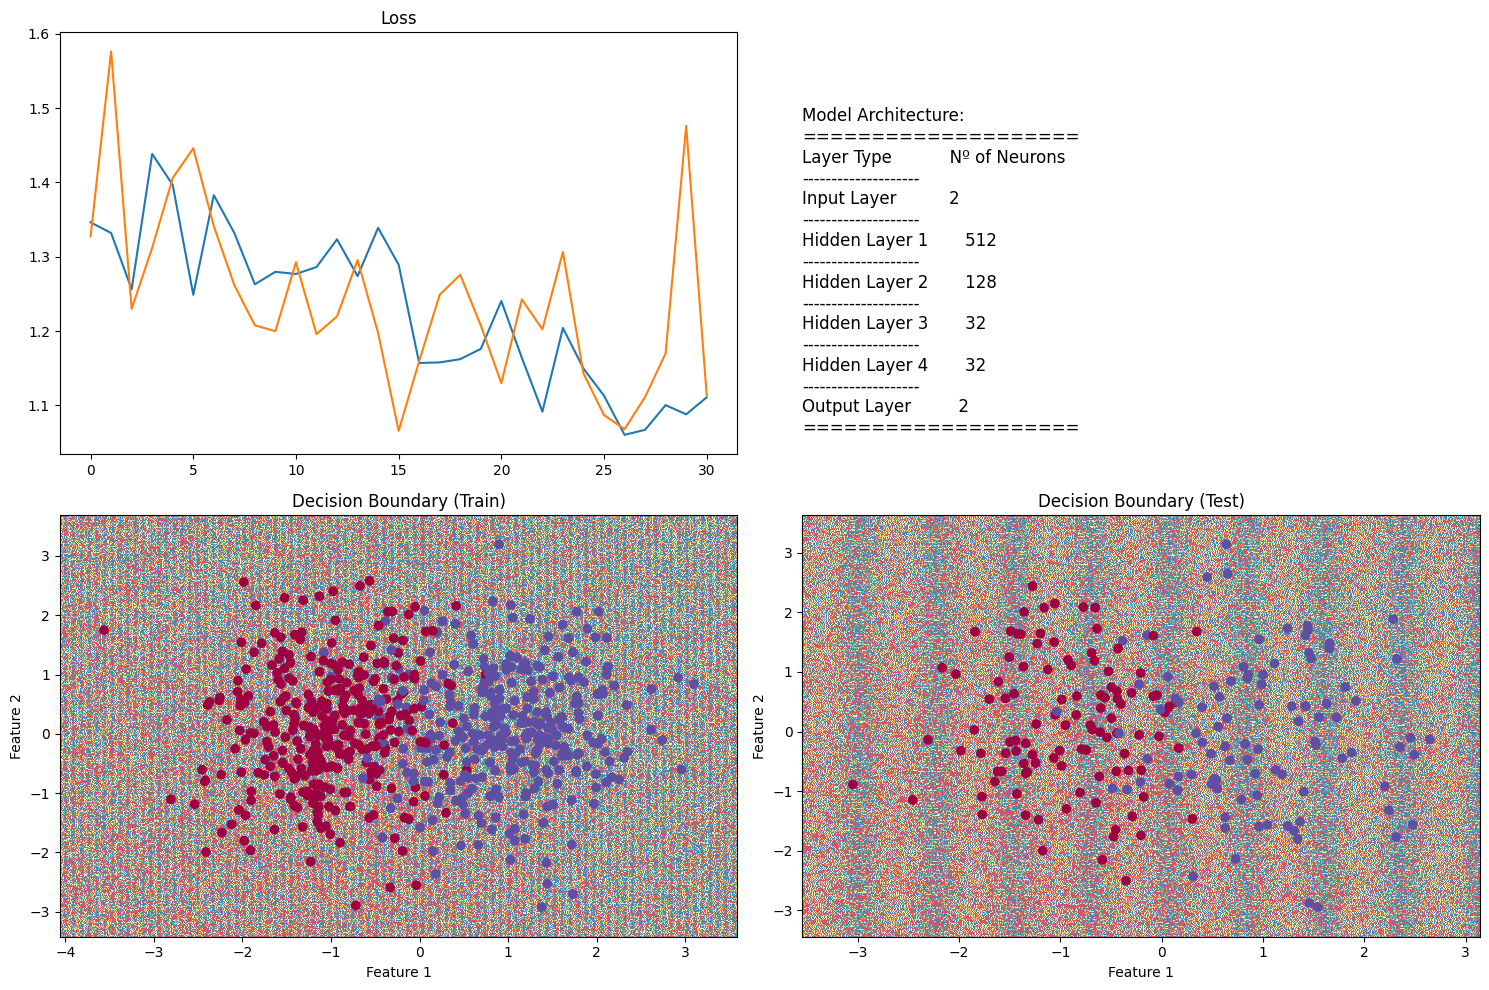

In [20]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[3])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(len(nn.losses)), nn.losses)
axes[0, 0].plot(range(len(nn.val_losses)), nn.val_losses)
axes[0, 0].set_title("Loss")

axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[3], yy_train[3], Z_train[3], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[3], yy_test[3], Z_test[3], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# **Questions**

1. **What other regularization techniques do you know? Comment them**

Otras técnicas de regularización que se pueden utilizar son:

- Regularización L1: esta se utiliza para reducir la complejidad del modelo, reduciendo las ponderaciones asociadas a las características menos importantes, lo que permite eliminar características poco frecuentas, ruidosas o irrelevantes.

- Regularización L2: esta técnica se utiliza para reducir la complejidad del modelo, penalizando las ponderaciones de las características menos importantes, lo que permite reducir el sobreajuste.

- Weight Decay: Esta técnica podríamos decir que es idéntica a la regularización L2, pero aplicada en otro punto. En lugar de introducir la penalización como un sumando en la función de coste, la añadimos como un término extra en la fórmula de actualización de los pesos


